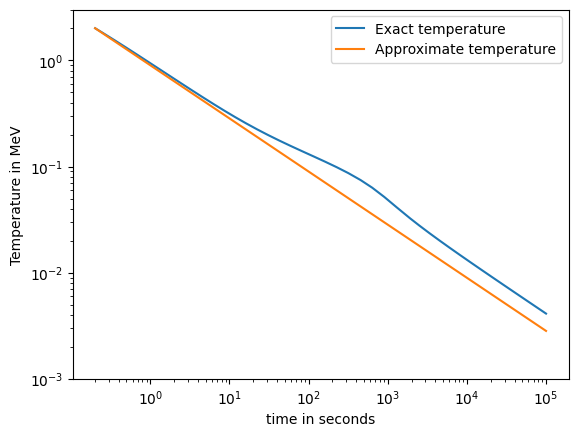

1.4554436917473483


In [1]:
#Background

import scipy.constants as con
#import scipy as sp
import numpy as np
from scipy import special
from scipy import integrate
from scipy.optimize import root_scalar

import matplotlib.pyplot as plt


#Special functions og deres afledte
def L(z):
    return special.kn(2,z)/z

def M(z):
    return (3/4*special.kn(3,z)+1/4*special.kn(1,z))/z

def dMdz(z):
    return -3/z**2*special.kn(3,z) -special.kn(2,z)

def N(z):
    return (1/2*special.kn(4,z)+1/2*special.kn(2,z))/z


timeunit =1.519*10**21  #MeV/hbar in unit of 1/second 
n_life=879.6*timeunit   #Neutron lifetime in units of MeV/hbar
Q=1.293                 #neutron proton mass difference in MeV
M_u=931                 #atomic mass unit in MeV
SBC=np.pi**2/60         #Stefan-Boltzmann constant in natural units
G=6.709e-45             #gravatational constant in units of c=hbar=MeV=1
infapprox=1e3           #large number acting as upper limit on itegrals


TMeV2T9=11.60451812 #conversion factor from MeV to 10^9K

T_ini=2 #initial temperature in MeV
e_mass=0.51099895 #electron mass in MeV
z_ini=e_mass/T_ini

def rho_e(T): #electron/positron density, chemical potential assumed to be 0 so cosh(phi*n)=1
    z=e_mass/T
    '''
    func=lambda x: np.real(2/(np.pi**2)*e_mass**4*((x**2*(x**2-1)**0.5)/((np.exp(z*x)+1))))

    result, error = integrate.quad(func, 0, infapprox)#[0]
    return result
    '''
    return 2/np.pi**2*e_mass**4*np.sum([(-1)**(n+1)*M(n*z) for n in range(1,10)])

def drho_e(T): #derivative of rho_e with respect to temperature
    z=e_mass/T
    '''
    func=lambda x: np.real(2/(np.pi**2)*e_mass**4*((x**2*(x**2-1)**0.5)*(z*x*np.exp(z*x))/(T*(np.exp(z*x)+1)**2)))

    result, error = integrate.quad(func, 0, infapprox)#[0]
    return result
    '''
    return 2/np.pi**2*e_mass**4*np.sum([(-1)**(n)*n*z/T*dMdz(n*z) for n in range(1,10)])


def P_e(T): #electron/positron pressure
    z=e_mass/T
    '''
    func=lambda x: 2/(3*np.pi**2)*e_mass**4*((x**4*(x**2+1)**-0.5)/((np.exp(z*(x**2+1)**0.5)+1)))

    result, error = integrate.quad(func, 0, infapprox)#[0]
    return result
    '''
    #Fowler and Hoyle 1964
    #return 4/np.pi**2*T**4*np.sum([(-1)**(n+1)/n**4*special.kn(2,n*z) for n in range(1,10)])
    
    #Kawano
    return 2/np.pi**2*e_mass**4*np.sum([(-1)**(n+1)/(n*z)*L(n*z) for n in range(1,10)])  



def rho_gamma(T):   #photon energy density
    return (np.pi**2)/15*T**4 

def drho_gamma(T):  #derivative
    return 4*(np.pi**2)/15*T**3 

def P_gamma(T):     #photon pressure
    return rho_gamma(T)/3



### Initial conditions ###

n_gamma_ini= 1.20206*2/np.pi**2*T_ini**3    #initial number density of photons based on theory
n_gamma_ini= rho_gamma(T_ini)/(2.701*T_ini) #initial number density of photons based mean photon energy

eta=6.1e-10     #CMB baryon-to-photon ratio
eta_ini=eta*(1+(rho_e(T_ini)+P_e(T_ini))/(rho_gamma(T_ini)+P_gamma(T_ini))) #entropi bevarelse


rho_nu_ini=7/8*(np.pi**2)/15*T_ini**4 #initial neutrino density

h_ini=M_u/T_ini**3*eta*n_gamma_ini  #initial h

t_ini=1.226*10**21/T_ini**2 #initial time in hbar/MeV

rho_b_ini=h_ini*T_ini**3*0     #initial baryon density, currently set to 0

rho_tot_ini=rho_e(T_ini)+rho_gamma(T_ini)+rho_nu_ini+rho_b_ini  #initial total energy density

H_ini=np.sqrt(8*np.pi/3*G*rho_tot_ini)


def rho_nu(T,a): #neutrina energy density
    #return 7/8*np.pi**2/15*T**4
    return rho_nu_ini/a**4



### Solving the background ###

def rho_tot(T,h,a): #total density
    return rho_e(T)+rho_gamma(T)+rho_nu(T,a)#+rho_b(T,h,a)

def rho_set(T,h): #total density of non-decoupled components
    return rho_e(T)+rho_gamma(T)#+rho_b(T,h,a)

def H(T,h,a):   #Hubble parameter as given by Friedmann eq, ignoring cosmological constant
    return np.sqrt(8*np.pi/3*G*rho_tot(T,h,a))



#Derivative from Kavano D.18
def dTdt(t,T,h,a):
    return -3*H(T,h,a)/((drho_e(T)+drho_gamma(T))/(rho_set(T,h) + P_e(T)+P_gamma(T) ))

#Derivative from Kavano D.19
def dhdt(t,T,h,a):
    return -3*h*(H(T,h,a)+dTdt(t,T,h,a)/T)

#Derivative from how H is defined
def dadt(t,T,h,a):
    return a*H(T,h,a)


t_range=[t_ini,1e5*timeunit]            #time range for integration
t_space=np.linspace(*t_range,1000)      #time range for approximate temperature

#combining derivatives
def dbackground(t,y):   #solve h and T, y[0] = T, y[1] = h and y[2] = a
    return [dTdt(t,*y),dhdt(t,*y),dadt(t,*y)]



# Solving it
sol = integrate.solve_ivp(dbackground, t_range, [T_ini,h_ini,1],method='Radau')#,t_eval=t_space)


# Plot the Temperature
plt.plot(sol.t/timeunit, sol.y[0], label='Exact temperature')

# Test with completely radiation dominated universe
t_space=sol.t
T_approx=np.sqrt(1.226*10**21/t_space)
plt.plot(t_space/timeunit, T_approx, label='Approximate temperature')


#plot the scale factor
#plt.plot(sol.t/timeunit, sol.y[2]/1e3, label='scale factor')

#fix the axis
plt.xlabel('time in seconds')
plt.ylabel('Temperature in MeV')

plt.xscale('log')
plt.yscale('log')

# plt.xlim((0.1, 2e5))
plt.ylim((1e-3,3))

plt.legend()
plt.show()

#test background temperature
print(sol.y[0][-1]/T_approx[-1])
